# Group 33 Project: Prediction of Diabetes Diagnosis #

Group members: Billie Beis-Leech, Anna Daoust, Fintan Casey, and Yash Mali

# Introduction

Diabetes is a health condition that affects how our bodies process nutrients into energy. Characterized by a deficiency of insulin, diabetes results in an abnormally high amount of glucose in the bloodstream. This can cause serious health problems, and so it is beneficial to predict in early stages.

Our study will answer the following predictive question: What is the diabetes status of a patient, given their medical profile? The Diabetes Prediction Dataset will be used to answer this question, containing medical and demographical data such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. Diabetes status is labeled with a 1 indicating the presence of diabetes, and a 0 indicating the absence. These findings can be used to analyze the functionality of these predictors, further developing our predictive models for diabetes status.

# Methods

From the Diabetes Prediction Dataset, the numerical predictors chosen for this study are age, BMI, HbA1c level, and blood glucose level. Both HbA1c levels and blood glucose levels are standard for predicting diabetes in patients, and higher levels are commonly used to diagnose and initiate treatment. Age is a crucial predictor because older age increases susceptibility to numerous health concerns, including diabetes. Therefore, age will be constricted to 18 years of age and older. Diabetes generally increases body mass, as the body needs to consume more nutrients to get glucose into cells when insulin is not properly functioning. As such, BMI is an ideal predictor and will be compared to the other predictors in data visualizations. Gender, hypertension, heart disease, and smoking history were not chosen as predictors in this study, as these variables are categorical and would not be as useful in formulating a knn classification model. 


To visualize the data, scatter plots will be presented as 2500 randomly generated data points to prevent overplotting. BMI is plotted with each predictor, creating a total of three plots. The data points will be colored in accordance with the diabetes diagnosis, either 'Not Diabetic' or 'Diabetic'. These predictors will then be used to train a classification model. The accuracy of this model will be computed to assess the functionality of the specified predictors of diabetes.

## Reading and wrangling the data

In [33]:
# loading the libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(cowplot)

In [3]:
# setting the seed
set.seed(1)

# loading the data
url <- "https://raw.githubusercontent.com/billiehbl/project_group33/main/diabetes_prediction_dataset.csv"
diabetes_data <- read_csv(url)

# tidying the data
tidy_diabetes <- diabetes_data |> filter(smoking_history != "No Info") |> filter(gender != 'Other')|>
    filter(age >= 2)|> mutate(diabetes = as_factor(diabetes))

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Splitting into testing and training data sets

In [6]:
# creating the training / testing split
diabetes_split <- initial_split(tidy_diabetes, prop = 0.70, strata = diabetes)
diabetes_train <- training(diabetes_split)
diabetes_train = diabetes_train[sample(1:nrow(diabetes_train)), ] # shuffles data frame
diabetes_test <- testing(diabetes_split)

## Summary statistics

*Calculating the number and percentage of observations in each category*

In [30]:
nrow_diabetes <- nrow(diabetes_train)
training_counts <- diabetes_train |>
    group_by(diabetes) |>
    summarize(count = n(), percentage = n() / nrow_diabetes)
training_counts

diabetes,count,percentage
<fct>,<int>,<dbl>
0,39876,0.8899304
1,4932,0.1100696


Table 1. ...

*Calculating summary statistics for predictor variables*

In [8]:
# calculating means for each predictor variable
means <- diabetes_train |>
        summarize(age = mean(age), bmi = mean(bmi),
        HbA1c = mean(HbA1c_level), blood_glucose = mean(blood_glucose_level))
tidy_means <- pivot_longer(means, cols = age:blood_glucose,
        names_to = "factor", values_to = "mean")

# calculating minimum values for each predictor variable
mins <- diabetes_train |>
        summarize(age = min(age), bmi = min(bmi),
        HbA1c = min(HbA1c_level), blood_glucose = min(blood_glucose_level))
tidy_mins <- pivot_longer(mins, cols = age:blood_glucose,
        names_to = "factor", values_to = "minimum")

# calculating maximum values for each predictor variable
maximum <- diabetes_train |>
        summarize(age = max(age), bmi = max(bmi),
        HbA1c = max(HbA1c_level), blood_glucose = max(blood_glucose_level))
tidy_max <- pivot_longer(maximum, cols = age:blood_glucose,
        names_to = "factor", values_to = "maximum")

# creating final summary table
summary <- tidy_means |>
        bind_cols(tidy_mins |> select(minimum)) |>
        bind_cols(tidy_max |> select(maximum))
summary

factor,mean,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>
age,46.585297,2.00,80.00
bmi,28.456706,10.08,88.76
HbA1c,5.565377,3.50,9.00
blood_glucose,139.656691,80.00,300.00


Table 2. ...

## Exploratory visualizations

*Creating a smaller sample from the data*

In [9]:
diabetes_sample <- diabetes_train |>
    sample_n(2500)

*Making the visualizations*

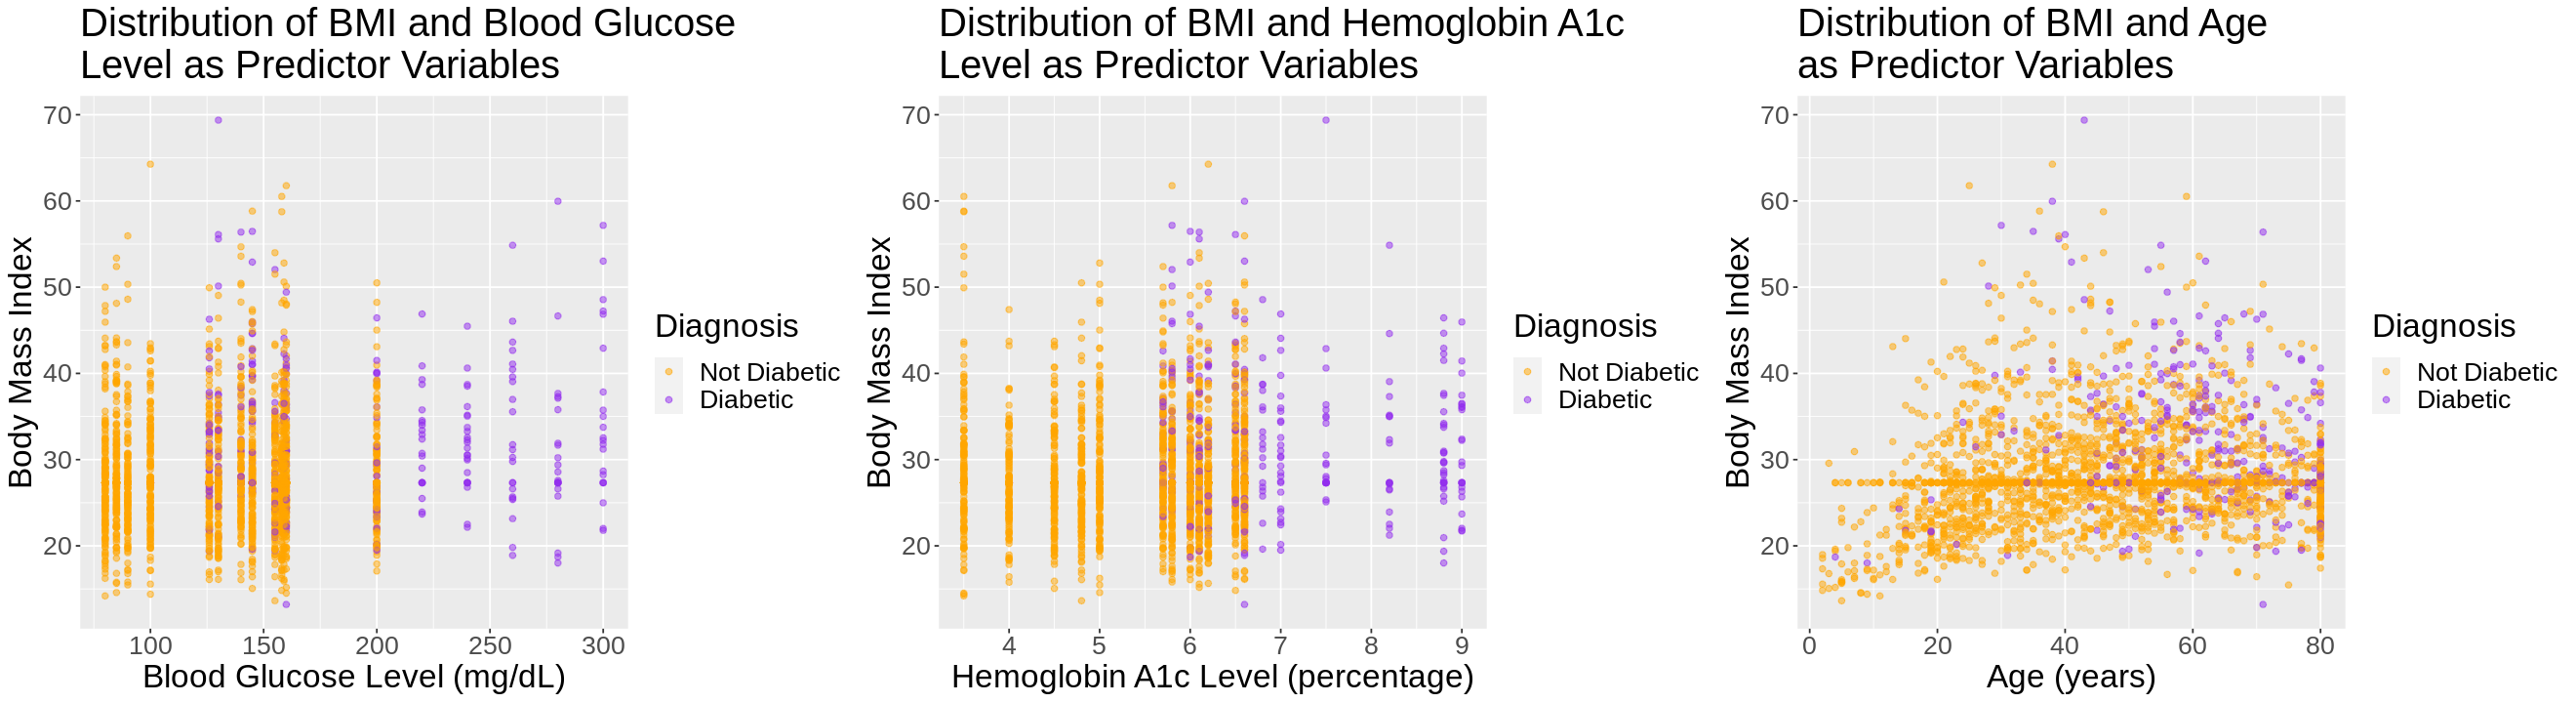

In [45]:
options(repr.plot.width = 22, repr.plot.height = 6)

# creating graph of the distribution of BMI and blood glucose predictors
bmi_blood_glucose <- diabetes_sample |>
    ggplot(aes(x = blood_glucose_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Blood Glucose Level (mg/dL)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Blood Glucose \nLevel as Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

# creating graph of the distribution of BMI and hemoglobin A1c predictors
bmi_HbA1c <- diabetes_sample |>
    ggplot(aes(x = HbA1c_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Hemoglobin A1c Level (percentage)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Hemoglobin A1c \nLevel as Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

# creating graph of the distribution of BMI and age predictors
bmi_age <- diabetes_sample |>
    ggplot(aes(x = age, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Age \nas Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

plot_grid(bmi_blood_glucose, bmi_HbA1c, bmi_age,
          ncol = 3)

Figure 1. ...

# Results

## Data analysis

*Tuning the model*

In [19]:
# creating recipe and scaling predictors
diabetes_recipe <- recipe(diabetes ~ bmi + HbA1c_level + blood_glucose_level + age,
                          data = diabetes_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# specifying k values for tuning
kvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# creating tuning specifications
diabetes_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# creating folds for cross-validation
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = diabetes)

# calculating accuracies for each k value
diabetes_accuracies <- workflow() |>
        add_recipe(diabetes_recipe) |>
        add_model(diabetes_tune) |>
        tune_grid(resamples = diabetes_vfold, grid = kvals) |>
        collect_metrics() |>
        filter(.metric == "accuracy")
diabetes_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9378015,5,0.0013547921,Preprocessor1_Model01
2,accuracy,binary,0.9379130,5,0.0013353619,Preprocessor1_Model02
3,accuracy,binary,0.9512364,5,0.0005456416,Preprocessor1_Model03
4,accuracy,binary,0.9513480,5,0.0005247684,Preprocessor1_Model04
5,accuracy,binary,0.9532897,5,0.0007096141,Preprocessor1_Model05
6,accuracy,binary,0.9532673,5,0.0006853181,Preprocessor1_Model06
7,accuracy,binary,0.9545840,5,0.0004123858,Preprocessor1_Model07
8,accuracy,binary,0.9546287,5,0.0003838174,Preprocessor1_Model08
9,accuracy,binary,0.9552759,5,0.0004502693,Preprocessor1_Model09


Table 3. ...

*Plotting the accuracies*

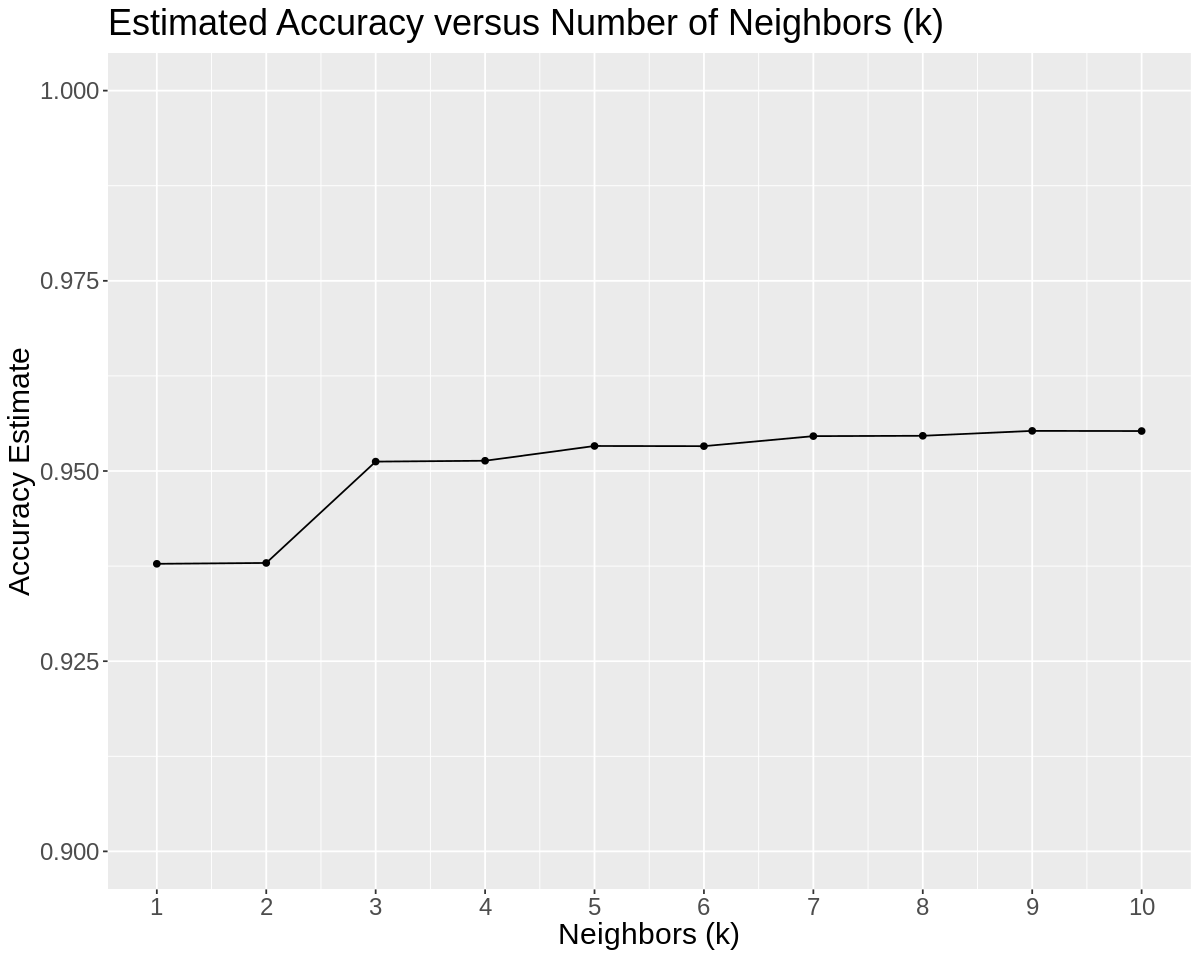

In [26]:
accuracy_versus_k <- ggplot(diabetes_accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
        scale_x_continuous(breaks = seq(0, 25, by = 1)) +  
        scale_y_continuous(limits = c(0.9, 1.0)) +
        theme(text = element_text(size = 18)) +         
        ggtitle("Estimated Accuracy versus Number of Neighbors (k)")
accuracy_versus_k

Figure 2. ...

*Re-training the model*

In [46]:
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification") 

diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(diabetes_spec) |>
    fit(data = diabetes_train)

*Evaluating the classifier's accuracy on the testing set*

In [47]:
diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)

diabetes_metrics <- diabetes_predictions |>
    metrics(truth = diabetes, estimate = .pred_class) |>
    filter(.metric == "accuracy")
diabetes_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.952562


Table 4. ...

*Generating the confusion matrix*

In [25]:
diabetes_conf_mat <- diabetes_predictions |>
    conf_mat(truth = diabetes, estimate = .pred_class)
diabetes_conf_mat

          Truth
Prediction     0     1
         0 16831   652
         1   259  1462

Table 5. ...

## Visualization of results

# Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?


1. summarize what you found

The results show that high values of age, BMI, blood glucose and hemoglobin A1c are generally correlated with being diagnosed with Diabetes Mellitus. 
	In the “Distribution of BMI and Age as Predictor Variables” graph, we see that the highest BMI value has a diabetic label and that the majority of diabetic labels have a value above a BMI of 30. Moreover, this graph also shows that the majority of points with the diabetic label are after the age of 40, indicating that the older one is, the more likely they are to contract diabetes.
	In the “Distribution of BMI and Hemoglobin A1c Level as Predictor Variables” graph, it is evident that the majority of values with the diabetic label are valued between 6 to 9 for the Hemoglobin A1c level, compared to the not-diabetic label valued between 3.5 to 6.5. This implies that the higher one’s Hemoglobin A1c level, the more likely they are to be diagnosed with diabetes. Moreover, the highest value of BMI is associated with a diabetic label and, on average, the BMI values associated with the diabetic label are higher than those with a not-diabetic label.
	Lastly, in the “Distribution of BMI and Blood Glucose Level as Predictor Variables” graph, it is apparent that the highest levels of blood glucose are associated with the diabetic label. Furthermore, on average, the BMI associated with the diabetic label has points that are higher in value than that of the not-diabetic labels.
    
2. discuss whether this is what you expected to find?

These are in fact results that we expected to find. As mentioned in the proposal, we stated that the individuals who score the highest in the predictor variables will be more likely to have diabetes compared to those who scored lower in these categories. It is quite well known that obesity has a very strong positive relationship with diabetes. For example, a large scale study conducted by Hartz et al. in 1983 measured the waist-to-hip girth ratio of around 15,500 women. The study’s results showed that “the prevalence of diabetes increased with increasing values of this ratio” and that women who were ranked in the upper 25% were three times more likely to have diabetes compared to women who were ranked in the lower 25%. Lastly, Hartz found that women who had serious obesity “had a relative risk of diabetes 10.3 times as great as nonobese subjects” (Hartz et al., 1983).

3. discuss what impact could such findings have?

After finding that those who are older and have higher BMIs, blood glucose and hemoglobin A1c levels,  we can work towards developing predictive/early detection models and risk assessment tools to identify the individuals who are at high risk for diabetes. In this way, these findings can help healthcare professionals initiate prevention strategies and provide interventions to improve patient outcomes. As a result of this, the prevalence of diabetes would not present as much of a burden on healthcare systems because it would pose less strain on diagnostics, infrastructure, and disease management.
	And lastly, these findings could have a significant impact on the importance of public health interventions to address the underlying causes of high BMI and blood glucose levels. Interventions could include campaigns to promote healthy lifestyles such as Hypocaloric diets combined with education and low-impact exercise. Another intervention could result in policies being enforced that improve access to nutritious food.

4. discuss what future questions could this lead to?

These results can lead to many possible future questions. An important question to consider is how our specific variables (Body Mass Index, blood glucose, and Hemoglobin A1c level) interact with factors such as socioeconomic status to influence the risk of contracting diabetes. For example, a study conducted by Brancati et al. found that participants who were overweight and had more fatty tissue, “had lower socioeconomic status.” Moreover, Brancati highlights that the prevalence of diabetes “was greatest in individuals of low socioeconomic status” and “least among individuals of high socioeconomic status.” We can go further than this and question if genetic predispositions or other lifestyle factors can also increase the susceptibility of being diagnosed with diabetes (Brancati et al., 1996).

# References

Brancati, F. L., Whelton, P. K., Kuller, L. H., & Klag, M. J. (1996c). Diabetes mellitus, race, and socioeconomic status a population-based study. Annals of Epidemiology, 6(1), 67–73. https://doi.org/10.1016/1047-2797(95)00095-x

Hartz, A. J., Rupley, D. C., Kalkhoff, R. K., & Rimm, A. A. (1983). Relationship of obesity to diabetes: Influence of obesity level and body fat distribution,. Preventive Medicine, 12(2), 351–357. https://doi.org/10.1016/0091-7435(83)90244-x

Mohammed Mustafa. 2023. "Diabetes prediction dataset: A Comprehensive Dataset for Predicting Diabetes with Medical & Demographic Data", Version 1.